# Classifying images with ResNet and DenseNet

## Import libaries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# to hide warnings or atleast some of them (caused by mapping with lambda)
# the warnings are not present in colab
import logging
logging.getLogger("tensorflow").disabled = True

## Load Dataset

In [2]:
(train_image, train_label), (test_image, test_label) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


## Preprocess the data

In [3]:
# Combine images and labels into a tf dataset
train_image = tf.data.Dataset.from_tensor_slices(train_image)
train_label = tf.data.Dataset.from_tensor_slices(train_label)
test_image = tf.data.Dataset.from_tensor_slices(test_image)
test_label = tf.data.Dataset.from_tensor_slices(test_label)

train_dataset = tf.data.Dataset.zip((train_image, train_label))
test_dataset = tf.data.Dataset.zip((test_image, test_label))                                                
            
    
# Shuffle data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)                                                


# Create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)


# Normalize images and encode labels onehot
train_dataset = train_dataset.map(lambda image, label: 
                                          (2*(image/255)-1, tf.squeeze(tf.one_hot(label, 10))), 
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.map(lambda image, label: 
                                            (2*(image/255)-1,  tf.squeeze(tf.one_hot(label, 10))), 
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()


# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# ResNet

## Define ResidualBlock

A Residual Block consists of alterations between
- Convolutional layer
- Batch Normalization layer


In [4]:
from tensorflow.keras import Model

class ResidualBlock(Model): 
    
    # we can pass certain filter counts, kernel sizes and strides
    # to initialize each layer of the ResidualBlock
    def __init__(self, segment_num, filters, kernel_sizes, strides):
        super(ResidualBlock, self).__init__()
        
        # Layer collection
        self.Layers = []
        
        # for each segment we create a 
        # convolutional layer 
        # batch norm layer
        # activation
        # and add them to our Layer collection for our ResidualBlock
        for index in range(segment_num):
            
            self.Layers.append(tf.keras.layers.Conv2D(
                                    filters = filters[index],
                                    kernel_size = kernel_sizes[index],
                                    strides = strides[index],
                                    padding ='same',
                                    activation = None))
            
            self.Layers.append(tf.keras.layers.BatchNormalization())
       
            self.Layers.append(tf.keras.activations.relu)
       

    def call(self, x, training):
        input = x
        for Layer in self.Layers:
            # if the Layer is a batch norm, we need to pass the training parameter
            if type(Layer) == tf.python.keras.layers.normalization_v2.BatchNormalization:
                x = Layer(x, training)
            else:
                x = Layer(x)
                
        # after pushing the input through the Residual Block
        # we add the initial input
        return x + input

## Define ResNet

In [5]:
class ResNet(Model): 
    
    # we can pass how many Residual Blocks we want in our Res Net
    # and how many segments they should have respectively
    # and also the information for each block
    def __init__(self, residual_blocks, segment_num, filters, kernel_sizes, strides):
        super(ResNet, self).__init__()
        
        # The first thing we need is a Convolutional Layer 
        # that can take our input images (define input_shape)
        self.convolutional_layer = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='relu',
            input_shape= (32, 32, 3))
        
        # Now we can create the residual Blocks
        self.Blocks = []
        for i in range(residual_blocks):
            self.Blocks.append(ResidualBlock(segment_num[i], filters[i], kernel_sizes[i], strides[i]))
            
        # Before the Output Layer we need a global average pool
        self.global_average_pooling_layer = tf.keras.layers.GlobalAvgPool2D()
        
        # Last but not least we define our Output Layer
        self.output_layer = tf.keras.layers.Dense(
            units=10,
            activation='softmax')

    def call(self, x, training):
        
        x = self.convolutional_layer(x)
        
        for Block in self.Blocks:
            x = Block(x)
        
        x = self.global_average_pooling_layer(x)
        
        x = self.output_layer(x)
        
        return x 

## Define traning and testing

In [6]:
def train_step(model, input, target, loss_function, optimizer, training = True):
    with tf.GradientTape() as tape:
        prediction = model(input, training)
        loss = loss_function(target, prediction) #+ tf.reduce_sum(model.losses)
        accuracy = np.mean(np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1))
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(model, test_data, loss_function, training = False):
    # Test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input, training)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.mean(np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1))
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Declare Model Structure
Before we can start the training we have to declare
<br>
how many Residual Blocks we want and with how many segments(ConvL + BatchNorm)

In [7]:
residual_blocks = 3

segment_num = [3,3,3]

filters = [[128, 256, 256],   # Block 1
           [128, 256, 256],   # Block 2
           [128, 256, 256]]   # Block 3

kernel_sizes = [[1, 3, 1],    # Block 1
                [1, 3, 1],    # Block 2
                [1, 3, 1]]    # Block 3

strides = [[1, 1, 1],         # Block 1
           [1, 1, 1],         # Block 2
           [1, 1, 1]]         # Block 3

residual_network = ResNet(residual_blocks, segment_num, filters, kernel_sizes, strides)

## Train the model

In [8]:
tf.keras.backend.clear_session()
from IPython.display import clear_output

def train_model(model, train_dataset, test_dataset):
  ### Hyperparameters
  num_epochs = 30
  learning_rate = 0.0001
  running_average_factor = 0.95

  # Initialize the loss
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

  # Initialize the optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  # Initialize lists for later visualization.
  train_losses = []
  train_accuracies = []

  test_losses = []
  test_accuracies = []

  # Testing model performance on train and test data before learning
  train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  test_loss, test_accuracy = test(residual_network, test_dataset, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # Train loop for num_epochs epochs.
  for epoch in range(num_epochs):
      print('Epoch: __ ' + str(epoch))

      train_dataset = train_dataset.shuffle(buffer_size=64)
      test_dataset = test_dataset.shuffle(buffer_size=64)

      # Training
      running_average_loss = 0
      running_average_accuracy = 0
      for (input,target) in train_dataset:
          train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
          running_average_loss = (running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss).numpy()
          running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
          
          
      train_losses.append(running_average_loss)
      train_accuracies.append(running_average_accuracy)

      # Testing
      test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

      clear_output(wait=True) 
      fontsize=24
      fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,10))
      ax[0].set_xlim((0,num_epochs))
      ax[0].plot(train_losses,label="Training")
      ax[0].plot(test_losses,label="Test")

      ax[1].set_ylim((0,1))
      ax[1].plot(train_accuracies,label="Training")
      ax[1].plot(test_accuracies,label="Test")

      ax[0].set_ylabel("Loss",fontsize=fontsize)
      ax[1].set_ylabel("Accuracy",fontsize=fontsize)
      ax[1].set_xlabel("Epochs",fontsize=fontsize)
      ax[1].axhline(0.85,xmax=num_epochs,c='g',ls='--')
      ax[0].legend()
      ax[1].legend()
      plt.show()

      print('Train loss: ',running_average_loss)
      print('Test loss: ',test_loss)
      print('Train accuracy: ',running_average_accuracy)
      print('Test accuracy: ',test_accuracy, "\n")

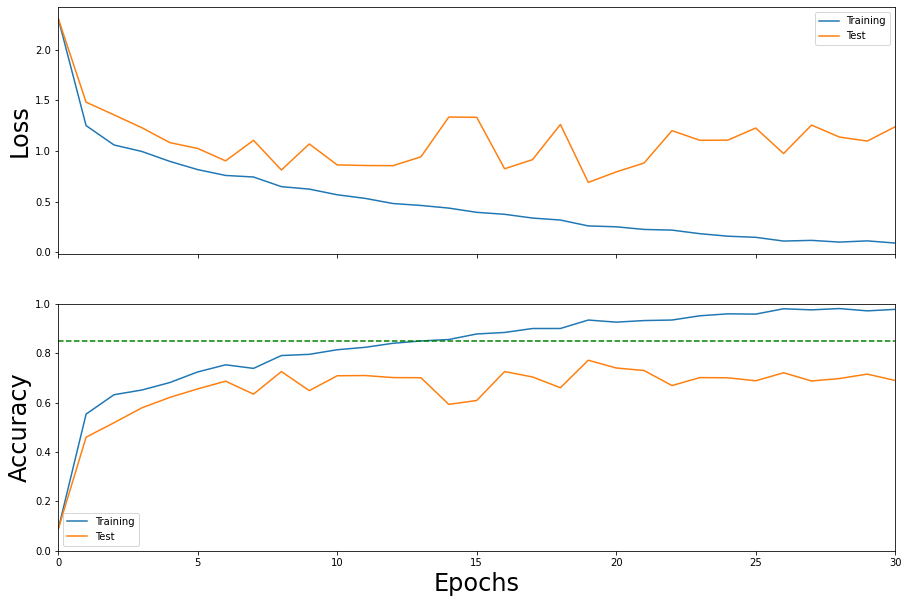

Train loss:  0.090825476
Test loss:  1.2390772
Train accuracy:  0.9771075186683553
Test accuracy:  0.6892914012738853 

CPU times: user 14min 45s, sys: 2min 3s, total: 16min 49s
Wall time: 1h 3min 58s


In [9]:
%%time
train_model(residual_network, train_dataset, test_dataset)

Time without @tf.function:

CPU times: 
- user 4min 46s,
- sys: 40.5 s, 
- total: 5min 27s


Wall time: 
- 21min 14s

<br>

with @tf.function:

CPU times: 
- user 4min 50s, 
- sys: 39.9 s, 
- total: 5min 30s


Wall time: 
- 21min 15s


## Get Model summary

In [10]:
residual_network.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  19456     
_________________________________________________________________
residual_block (ResidualBloc multiple                  396416    
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  396416    
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  396416    
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2570      
Total params: 1,211,274
Trainable params: 1,207,434
Non-trainable params: 3,840
_____________________________________________

# DenseNet

## structure of a DenseNet

- Set of Layers
  - Convolutional Layer
  - Pooling Layer
---
- Dense Block
  - any number of Convolutional Layers
- Transition Layer
  - Bottleneck Layer
  - Batch Norm
  - Activation
  - Pooling Layer

 ... (repeat the *framed* pattern as often as you want)
---
- Output Layers
  - Batch Norm Layer
  - Global Average Pool
  - Softmax Output



## Transition Layer

In [11]:
class TransitionLayer(Model): 
   
    def __init__(self):
        super(TransitionLayer, self).__init__()
        
        self.bottleneck =  tf.keras.layers.Conv2D(
            filters=20,
            kernel_size=1,
            strides=1,
            padding='same',
            activation=None)
        
        self.batch_norm = tf.keras.layers.BatchNormalization()

        self.activation = tf.keras.activations.relu

    def call(self, x, training):
        x = self.bottleneck(x)
        x = self.batch_norm(x, training)
        x = self.activation(x)
        return x 

## Dense Block

When we want to create a new Dense Block <br>
we need to pass the details for each Layer, <br>
so filters, kernel size and strides

In [12]:
class DenseBlock(Model): 
   
    def __init__(self, convl_num, filters, kernel_sizes, strides):
        super(DenseBlock, self).__init__()
        
        self.Layers = []

        for i in range(convl_num):
          self.Layers.append(tf.keras.layers.Conv2D(
                  filters = filters[i],
                  kernel_size = kernel_sizes[i],
                  strides = strides[i],
                  padding = 'same',
                  activation = tf.keras.activations.relu))

    def call(self, x):
      for Layer in self.Layers:
        input = x
        x = Layer(x)
        x = tf.keras.layers.Concatenate()([input, x])
      return x 


## Dense Net

In [13]:
class DenseNet(Model): 
   
    def __init__(self, segment_num, convl_num, filters, kernel_sizes, strides):
        super(DenseNet, self).__init__()
        
        # We start with a proper Convolutional Layer that can take the input images
        self.convolutional_layer = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='relu',
            input_shape= (32, 32, 3))
        
        # Then we alter between Dense Blocks and Transition layers
        self.segments = []
        for i in range(segment_num):
          self.segments.append(DenseBlock(convl_num[i], filters[i], kernel_sizes[i], strides[i]))
          self.segments.append(TransitionLayer())
          
        # Before the Output Layer we need a batch norm layer and a global average pool
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.global_average_pooling_layer = tf.keras.layers.GlobalAvgPool2D()
        
        # Last but not least we define our Output Layer
        self.output_layer = tf.keras.layers.Dense(
            units=10,
            activation='softmax')
        


    def call(self, x, training):
      x = self.convolutional_layer(x)
      for segment in self.segments:
        if type(segment) == TransitionLayer:
          x = segment(x, training)
        else:
          x = segment(x)

      x = self.batch_norm(x, training)
      x = self.global_average_pooling_layer(x)
      x = self.output_layer(x)

      return x 

## Declare Model Structure

In [14]:
# Number of Dense Blocks and Transition layers
segment_num = 3

# Number of ConvL per Dense Block
convl_num = [3,3,3]

filters = [[128, 256, 256],   # Block 1
           [128, 256, 256],   # Block 2
           [128, 256, 256]]   # Block 3

kernel_sizes = [[1, 3, 1],    # Block 1
                [1, 3, 1],    # Block 2
                [1, 3, 1]]    # Block 3

strides = [[1, 1, 1],         # Block 1
           [1, 1, 1],         # Block 2
           [1, 1, 1]]         # Block 3

dense_net = DenseNet(segment_num, convl_num, filters, kernel_sizes, strides)

## Train the model

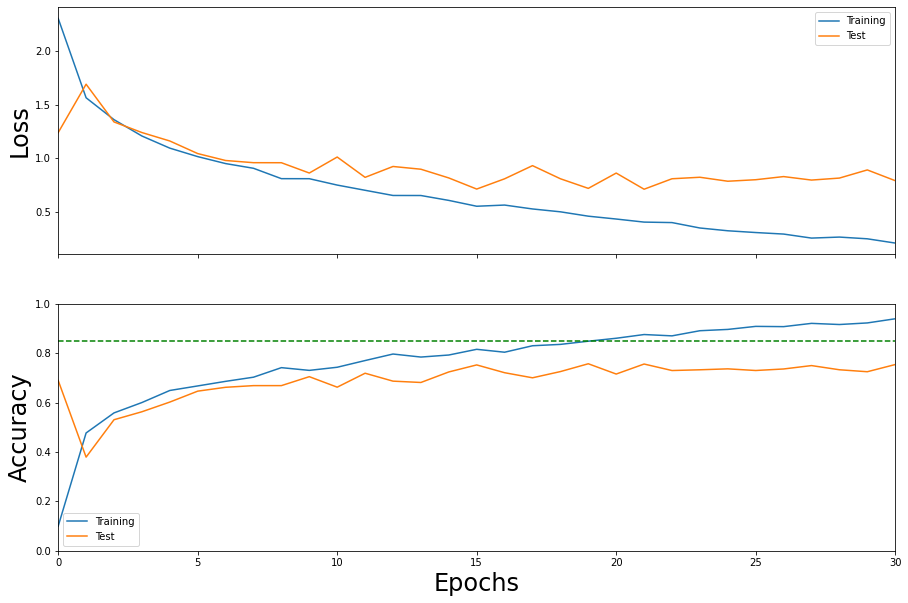

Train loss:  0.21013291
Test loss:  0.7913203
Train accuracy:  0.9390210572593606
Test accuracy:  0.753781847133758 

CPU times: user 18min 45s, sys: 2min 41s, total: 21min 27s
Wall time: 1h 23min 4s


In [15]:
%%time
train_model(dense_net, train_dataset, test_dataset)

In [16]:
dense_net.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  19456     
_________________________________________________________________
dense_block (DenseBlock)     multiple                  1081984   
_________________________________________________________________
transition_layer (Transition multiple                  18020     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  447616    
_________________________________________________________________
transition_layer_1 (Transiti multiple                  13300     
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  447616    
_________________________________________________________________
transition_layer_2 (Transiti multiple                  13